In [1]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb,albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2,torchvision
from timm.loss import SoftTargetCrossEntropy
from timm.data.mixup import Mixup
from timm.scheduler import CosineLRScheduler
from timm.optim.optim_factory import create_optimizer_v2
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d
from tqdm.auto import tqdm
from fastprogress.fastprogress import format_time
from ranger.ranger2020 import Ranger
from timm import utils

In [2]:
set_seed(42); set_fast_norm()
warnings.filterwarnings('ignore')

## Config

In [3]:
DATA_PATH = Path('/data/')
CSV_PATH = DATA_PATH/'train.csv'
FOLD_PATH = DATA_PATH/'train_folds.csv'
IMAGE_FOLDER = DATA_PATH/'train'

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

VERSION = "NB_EXP_V2_005"
MODEL = "swin_large_patch4_window7_224_in22k"
BS = 32
SZ = 224
EP = 16
LR = 6e-05
WD = 1e-02

mixup_args = dict(mixup_alpha=0.4, cutmix_alpha=1.0, prob=0.6, 
                  switch_prob=0.5, label_smoothing=0.0, 
                  num_classes=len(LABELS))

MODEL_FOLDER = Path(f"/runs/{VERSION}/")
MODEL_FOLDER.mkdir(exist_ok=True)

KERNEL_TYPE = f"{MODEL}_{SZ}_bs{BS}_ep{EP}_lr{str(LR).replace('-','')}_wd{str(WD).replace('-','')}_mixup_cutmix"

print(MODEL_FOLDER)
print(KERNEL_TYPE)

/runs/NB_EXP_V2_005
swin_large_patch4_window7_224_in22k_224_bs32_ep16_lr6e05_wd0.01_mixup_cutmix


In [4]:
#!rm -R {MODEL_FOLDER}

In [5]:
folds = pd.read_csv(FOLD_PATH)
folds.head()

,seed_id,view,image,label,fold
0,0,top,train/00000.png,broken,0
1,1,bottom,train/00001.png,pure,3
2,3,top,train/00003.png,broken,2
3,4,top,train/00004.png,pure,3
4,5,top,train/00005.png,discolored,4


In [6]:
class LoadImagesAndLabels(torch.utils.data.Dataset):
    
    def __init__(self, df, transforms, mode='train'):
        self.df = df
        self.transforms = transforms
        self.mode = mode
        
    def __len__(self): return len(self.df)
    
    def __getitem__(self,index):
        row = self.df.iloc[index]
        img_path = str(DATA_PATH/row.image)
        
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        
        if self.transforms is not None:
            img = self.transforms(image=img)['image']
        
        if self.mode == 'test':
            return img
            
        label = torch.tensor(labels_class_map[row.label]).long()
        return img, label

## Augmentations

In [7]:
TRAIN_AUG = A.Compose([
    A.RandomResizedCrop(SZ, SZ, scale=(0.72, 1.0), p=1.0),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(rotate_limit=360, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Blur(p=0.5),
    A.CoarseDropout(max_height=int(32*(SZ/512)), max_width=int(32*(SZ/512)), p=0.75),
    A.Normalize(),
    ToTensorV2(),
])

VALID_AUG = A.Compose([
    A.SmallestMaxSize(max_size=SZ + 16, p=1.0),
    A.CenterCrop(height=SZ, width=SZ, p=1.0),
    A.Normalize(),
    ToTensorV2(),
])

## Visualization

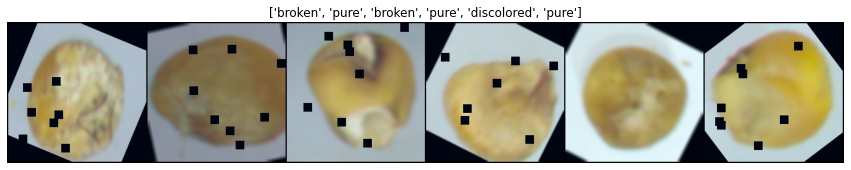

In [8]:
dataset_show = LoadImagesAndLabels(folds, TRAIN_AUG, mode='train')
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=6)
img,target = next(iter(loader_show))

grid = torchvision.utils.make_grid(img, normalize=True, padding=2)
grid = grid.permute(1, 2, 0)
show_image(grid, figsize=(15,8), title=[labels_class_map_rev[x] for x in target.numpy()]);

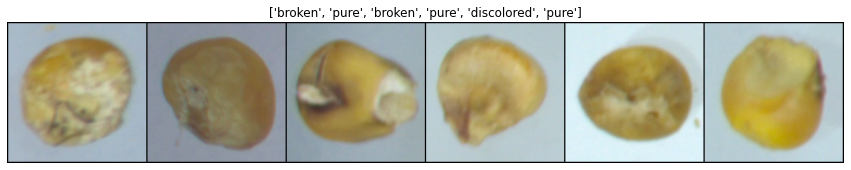

In [9]:
dataset_show = LoadImagesAndLabels(folds, VALID_AUG, mode='train')
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=6)
img,target = next(iter(loader_show))

grid = torchvision.utils.make_grid(img, normalize=True, padding=2)
grid = grid.permute(1, 2, 0)
show_image(grid, figsize=(15,8), title=[labels_class_map_rev[x] for x in target.numpy()]);

## Model

In [10]:
def get_corn_model(model_name, pretrained=True, **kwargs):
    model = timm.create_model(model_name, pretrained=pretrained, **kwargs)
    model = nn.Sequential(model, nn.Dropout(0.15), nn.Linear(model.num_classes, len(LABELS)))
    return model

## Train & Validation Function¶

In [11]:
def train_one_epoch(
    model:nn.Module, loader:Iterable, loss_fn:Callable, optimizer:torch.optim.Optimizer, 
    lr_scheduler:torch.optim.lr_scheduler._LRScheduler=None, mixup_fn:Callable=None, 
    grad_scaler: torch.cuda.amp.GradScaler=None, mbar: master_bar = None):
    
    model.train()
    
    losses_m = utils.AverageMeter()
    
    pbar = progress_bar(loader, parent=mbar, leave=False)
    pbar.update(0)
        
    for batch_idx, (input, target) in enumerate(loader):
        input, target = input.cuda(), target.cuda()
        input, target = mixup_fn(input, target)
                
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(input)
            loss = loss_fn(output, target)
        
        losses_m.update(loss.item(), input.size(0))
                
        grad_scaler.scale(loss).backward() 
        grad_scaler.step(optimizer)
        grad_scaler.update()
                
        if lr_scheduler is not None: 
            lr_scheduler.step()
            
        pbar.update(batch_idx+1)
        pbar.comment = f'{losses_m.avg:.4f}'
    
    pbar.on_iter_end()
    return OrderedDict([("loss", losses_m.avg)])
                


@torch.inference_mode()
def validate(model:nn.Module, loader:Iterable, loss_fn:Callable, mbar: master_bar):
    model.eval()
    
    accs_m = utils.AverageMeter()
    losses_m = utils.AverageMeter()
    
    pbar = progress_bar(loader, parent=mbar, leave=False)
    pbar.update(0)
    
    for batch_idx, (input, target) in enumerate(loader):
        input, target = input.cuda(), target.cuda()
        output = model(input)
        
        loss = loss_fn(output, target).item()
        losses_m.update(loss, input.size(0))
        
        acc = accuracy(output, target).item()
        accs_m.update(acc, output.size(0))
        
        pbar.update(batch_idx+1)
    
    pbar.on_iter_end()
    return OrderedDict([('loss', losses_m.avg), ('accuracy', accs_m.avg)])

## Run!

In [12]:
def training_loop(fold):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        print()
        print('*' * 100)
        print(f'Training fold {fold}')
        print('*' * 100)
        
        torch.backends.cudnn.benchmark = True
        
        dataset_train = LoadImagesAndLabels(folds.query('fold!=@fold'), transforms=TRAIN_AUG, mode="train")
        dataset_valid = LoadImagesAndLabels(folds.query('fold==@fold'), transforms=VALID_AUG, mode="valid")

        print(f"TRAIN: {len(dataset_train)} | VALID: {len(dataset_valid)}")
        
        loader_train = torch.utils.data.DataLoader(dataset_train, BS, num_workers=8, shuffle=True, drop_last=True)
        loader_valid = torch.utils.data.DataLoader(dataset_valid, BS*2, num_workers=8, shuffle=False)

        model = get_corn_model(MODEL, pretrained=True, drop_path_rate=0.3)
        model.cuda()

        optimizer = create_optimizer_v2(model,"adamw", lr=LR, weight_decay=WD)
        
        num_train_steps = len(loader_train) * EP
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_train_steps)
        
        mixup = Mixup(**mixup_args)
        
        train_loss_fn = SoftTargetCrossEntropy()
        valid_loss_fn = nn.CrossEntropyLoss()

        grad_scaler = torch.cuda.amp.GradScaler()
        
        print(f"Scheduled epochs: {EP}")
        
        mbar = master_bar(list(range(EP)))
        best_epoch, best_metric = 0, 0
        metric_names = ["epoch", "train_loss", "valid_loss", "accuracy", "time"]
        mbar.write([f'{l:.6f}' if isinstance(l, float) else str(l) for l in metric_names], table=True)
        
        for epoch in range(EP):
            start_time = time.time()
            mbar.update(epoch)
            
            train_metrics = train_one_epoch(
                model, loader_train, train_loss_fn, optimizer, 
                lr_scheduler=lr_scheduler, mixup_fn=mixup, grad_scaler=grad_scaler, mbar=mbar)
            
            valid_metrics = validate(model, loader_valid, valid_loss_fn, mbar=mbar)
            
            epoch_log = [epoch, train_metrics["loss"], valid_metrics["loss"], valid_metrics["accuracy"], format_time(time.time() - start_time)]
            mbar.write([f'{l:.6f}' if isinstance(l, float) else str(l) for l in epoch_log], table=True)
            
            if valid_metrics["accuracy"] > best_metric:
                best_epoch, best_metric = epoch, valid_metrics['accuracy']
                dirpath = MODEL_FOLDER/(KERNEL_TYPE + f"_CV_{fold}.pth")
                torch.save(model.state_dict(), dirpath)
            
        mbar.on_iter_end()
        print('*** Best metric: {0} (epoch {1})'.format(best_metric, best_epoch))

In [13]:
for fold_idx in range(5):
    training_loop(fold_idx)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 0
****************************************************************************************************
TRAIN: 11457 | VALID: 2865
Scheduled epochs: 16


epoch,train_loss,valid_loss,accuracy,time
0,0.951566,0.582036,0.760209,01:52
1,0.789059,0.591780,0.761257,01:50
2,0.745470,0.568464,0.783246,01:50
3,0.744053,0.542455,0.783595,01:50
4,0.728720,0.544360,0.796859,01:50
5,0.691519,0.523577,0.792670,01:50
6,0.689124,0.535489,0.799651,01:50
7,0.648630,0.571714,0.786038,01:50
8,0.648449,0.538639,0.801396,01:50
9,0.646188,0.512580,0.798953,01:50


*** Best metric: 0.8101221636743862 (epoch 15)
CPU: 2190/172/3640 MB | GPU: 4892/8294/5980 MB | Time 0:30:32.694 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 1
****************************************************************************************************
TRAIN: 11457 | VALID: 2865
Scheduled epochs: 16


epoch,train_loss,valid_loss,accuracy,time
0,0.946744,0.582871,0.768237,01:50
1,0.789689,0.540627,0.781501,01:50
2,0.757575,0.537750,0.784991,01:50
3,0.739377,0.557329,0.783944,01:50
4,0.726682,0.597685,0.787086,01:50
5,0.709461,0.525807,0.797208,01:50
6,0.694815,0.541915,0.789878,01:50
7,0.657178,0.491358,0.803141,01:50
8,0.648564,0.521330,0.798953,01:50
9,0.643696,0.492682,0.806981,01:50


*** Best metric: 0.812914485311425 (epoch 14)
CPU: 613/1125/3950 MB | GPU: 4032/10230/5800 MB | Time 0:30:33.250 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 2
****************************************************************************************************
TRAIN: 11458 | VALID: 2864
Scheduled epochs: 16


epoch,train_loss,valid_loss,accuracy,time
0,0.948048,0.648547,0.738478,01:50
1,0.787816,0.651274,0.746508,01:50
2,0.761569,0.570553,0.771997,01:50
3,0.734559,0.534501,0.796439,01:50
4,0.724070,0.518907,0.800279,01:50
5,0.700932,0.574151,0.784218,01:50
6,0.694100,0.552094,0.788757,01:50
7,0.648142,0.531015,0.802723,01:50
8,0.645369,0.529132,0.801327,01:50
9,0.636998,0.550213,0.805517,01:50


*** Best metric: 0.8111033522882941 (epoch 13)
CPU: 598/1125/3950 MB | GPU: 4072/10214/5830 MB | Time 0:30:28.137 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 3
****************************************************************************************************
TRAIN: 11458 | VALID: 2864
Scheduled epochs: 16


epoch,train_loss,valid_loss,accuracy,time
0,0.951267,0.591857,0.765363,01:50
1,0.809592,0.547266,0.785615,01:50
2,0.748525,0.507906,0.796089,01:50
3,0.746226,0.533990,0.792249,01:50
4,0.718054,0.525009,0.788059,01:50
5,0.704995,0.576790,0.778631,01:50
6,0.693478,0.494470,0.807612,01:50
7,0.659800,0.508202,0.802025,01:50
8,0.638399,0.534668,0.797137,01:50
9,0.645347,0.500037,0.806913,01:50


*** Best metric: 0.8121508383218137 (epoch 14)
CPU: 26/1696/3379 MB | GPU: 4062/10242/5830 MB | Time 0:30:08.849 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 4
****************************************************************************************************
TRAIN: 11458 | VALID: 2864
Scheduled epochs: 16


epoch,train_loss,valid_loss,accuracy,time
0,0.943751,0.541719,0.785964,01:50
1,0.786173,0.513861,0.799930,01:50
2,0.758573,0.534191,0.792947,01:50
3,0.740041,0.479452,0.804469,01:50
4,0.729949,0.563849,0.795391,01:50
5,0.705355,0.492499,0.806564,01:50
6,0.692385,0.475869,0.805866,01:50
7,0.653192,0.508153,0.811802,01:50
8,0.655038,0.458302,0.815293,01:50
9,0.648949,0.466302,0.815642,01:50


*** Best metric: 0.824371509045862 (epoch 12)
CPU: 580/1116/3960 MB | GPU: 4086/10236/5854 MB | Time 0:30:20.683 | (Consumed/Peaked/Used Total)


In [14]:
folds_val_score = []
for fold in range(5):
    CHECKPOINT = MODEL_FOLDER/(KERNEL_TYPE + f"_CV_{fold}.pth")
    
    model = get_corn_model(MODEL, pretrained=False)
    model.load_state_dict(torch.load(CHECKPOINT))
    model.eval()
    model.cuda()
    print(f'=> load from : {CHECKPOINT}')
    
    dataset_valid = LoadImagesAndLabels(folds.query('fold==@fold'), transforms=VALID_AUG, mode="valid")
    loader_valid = torch.utils.data.DataLoader(dataset_valid, BS*2, num_workers=8, shuffle=False)
    
    preds, targs = [],[]
    for input,target in tqdm(loader_valid, total=len(loader_valid), dynamic_ncols=True):
        with torch.cuda.amp.autocast(), torch.no_grad():
            input = input.cuda()
            
            output  = model(input)
            output += model(torch.flip(input, dims=(3,)))
            output += model(torch.flip(input, dims=(2,)))
            output += model(torch.flip(input, dims=(2,3)))
            
        preds.append(output.data.cpu())
        targs.append(target)
    
    preds = torch.cat(preds)
    targs = torch.cat(targs)
    
    acc = accuracy(preds, targs).item()
    print(f"* Accuracy : {acc}")
    print()
        
    folds_val_score.append(acc)
    
    
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

=> load from : /runs/NB_EXP_V2_005/swin_large_patch4_window7_224_in22k_224_bs32_ep16_lr6e05_wd0.01_mixup_cutmix_CV_0.pth


  0%|                                                                                                         …

* Accuracy : 0.811867356300354

=> load from : /runs/NB_EXP_V2_005/swin_large_patch4_window7_224_in22k_224_bs32_ep16_lr6e05_wd0.01_mixup_cutmix_CV_1.pth


  0%|                                                                                                         …

* Accuracy : 0.8164048790931702

=> load from : /runs/NB_EXP_V2_005/swin_large_patch4_window7_224_in22k_224_bs32_ep16_lr6e05_wd0.01_mixup_cutmix_CV_2.pth


  0%|                                                                                                         …

* Accuracy : 0.8131983280181885

=> load from : /runs/NB_EXP_V2_005/swin_large_patch4_window7_224_in22k_224_bs32_ep16_lr6e05_wd0.01_mixup_cutmix_CV_3.pth


  0%|                                                                                                         …

* Accuracy : 0.8187848925590515

=> load from : /runs/NB_EXP_V2_005/swin_large_patch4_window7_224_in22k_224_bs32_ep16_lr6e05_wd0.01_mixup_cutmix_CV_4.pth


  0%|                                                                                                         …

* Accuracy : 0.8212290406227112


****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.81187, 0.8164, 0.8132, 0.81878, 0.82123]
Avg: 0.81630
Std: 0.00346


In [34]:
# tst_csv = pd.read_csv(DATA_PATH/'test.csv')
# tst_csv = tst_csv.merge(pd.read_csv(DATA_PATH/'sample_submission.csv'), how="left")
# tst_csv = tst_csv.reset_index(drop=True, inplace=False)
# tst_csv.head()

In [35]:
# preds = None
# for fold in range(5):
#     CHECKPOINT = MODEL_FOLDER/(KERNEL_TYPE + f"_CV_{fold}.pth")
    
#     model = get_corn_model(MODEL, pretrained=False)
#     model.load_state_dict(torch.load(CHECKPOINT))
#     model.eval(); model.cuda()
#     print(f'=> load from : {CHECKPOINT}')
    
#     dataset_valid = LoadImagesAndLabels(tst_csv, transforms=VALID_AUG, mode="test")
#     loader_valid = torch.utils.data.DataLoader(dataset_valid, BS*2, num_workers=8, shuffle=False)
    
#     pred = []
#     for input in tqdm(loader_valid, total=len(loader_valid), dynamic_ncols=True):
#         input = input.cuda()
#         with torch.cuda.amp.autocast(), torch.no_grad():
#             output  = model(input)
#             output += model(torch.flip(input, dims=(3,)))
#             output += model(torch.flip(input, dims=(2,)))
#             output += model(torch.flip(input, dims=(2,3)))
#         pred.append(output.data.cpu())
#     pred = torch.cat(pred)
    
#     if preds is not None: preds += pred/5
#     else                : preds  = pred/5

In [36]:
# vals, inds = torch.max(preds, 1)
# submission_csv = pd.DataFrame()
# submission_csv['seed_id'] = tst_csv['seed_id']
# submission_csv['label'] = inds.tolist()
# submission_csv['label'] = submission_csv['label'].apply(lambda x: labels_class_map_rev[x])
# submission_csv.head()

In [33]:
# os.makedirs('/workspace/subs/', exist_ok=True)
# submission_csv.to_csv('/workspace/subs/sub_beit_base_patch16_224_224_bs32_ep16_lr2e05_wd1e08_mixup_cutmix_oofscore0.81679.csv', index=False)